# **Detecção de Intenções com Spacy**





Neste projeto, será mostrado uma aplicação simples com o Framework [Spacy](https://spacy.io/).

Spacy é um framework open source para auxiliar nas tarefas de NLP e NLU.
Frameworks famosos como [RASA](https://rasa.com/), [NLP Architect by Intel® AI Lab](http://nlp_architect.nervanasys.com/) dentre outros, utilizam o Spacy para auxiliar em suas tarefas.

Para este tutorial, foi utilizado a base de dados [SNIPS](https://github.com/ZephyrChenzf/SF-ID-Network-For-NLU/tree/master/data/snips) para a detecção de intenções utilizando o Spacy.

Para instalar o Spacy, utilize estes comandos:
> pip install spacy 

> python -m spacy download pt
 

## 1) Importar as bibliotecas


In [0]:
import sys
import numpy as np
import pandas as pd
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import balanced_accuracy_score



In [17]:
!python -m spacy download en
nlp = spacy.load("en")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


## 2) Obter as bases (SNIPS)

In [2]:
##Obtendo a base de train

!git clone https://github.com/ZephyrChenzf/SF-ID-Network-For-NLU.git

! git pull

Cloning into 'SF-ID-Network-For-NLU'...
remote: Enumerating objects: 84, done.
remote: Total 84 (delta 0), reused 0 (delta 0), pack-reused 84
Unpacking objects: 100% (84/84), done.
fatal: not a git repository (or any of the parent directories): .git


### 2.1)  Base de Treino



In [3]:
x_train =pd.read_csv("SF-ID-Network-For-NLU/data/snips/train/seq.in")
y_train =pd.read_csv("SF-ID-Network-For-NLU/data/snips/train/label")





df_train = pd.DataFrame(pd.concat([x_train,y_train],axis=1))
df_train.columns=['sentence','intent']

df_train

,sentence,intent
0,add step to me to the 50 clásicos playlist,AddToPlaylist
1,i give this current textbook a rating value of...,RateBook
2,play the song little robin redbreast,PlayMusic
3,please add iris dement to my playlist this is ...,AddToPlaylist
4,add slimm cutta calhoun to my this is prince p...,AddToPlaylist
...,...,...
13078,i want to eat choucroute at a brasserie for 8,BookRestaurant
13079,play funky heavy bluesy,PlayMusic
13080,rate the current album 2 points out of 6,RateBook
13081,go to the photograph the inflated tear,SearchCreativeWork


### 2.2) Base de Teste


In [4]:
## Importar a Base de treino

x_test =pd.read_csv("SF-ID-Network-For-NLU/data/snips/test/seq.in")
y_test =pd.read_csv("SF-ID-Network-For-NLU/data/snips/test/label")

df_test = pd.DataFrame(pd.concat([x_test,y_test],axis=1))
df_test.columns=['sentence','intent']

df_test

,sentence,intent
0,i want to bring four people to a place that s ...,BookRestaurant
1,put lindsey cardinale into my hillary clinton ...,AddToPlaylist
2,will it snow in mt on june 13 2038,GetWeather
3,play signe anderson chant music that is newest,PlayMusic
4,can you let me know what animated movies are p...,SearchScreeningEvent
...,...,...
694,find a tv series called armageddon summer,SearchCreativeWork
695,find politicsnation with al sharpton,SearchCreativeWork
696,rate this album 0 points out of 6,RateBook
697,add leah kauffman to my uncharted 4 nathan dra...,AddToPlaylist


## 3) Explorando a base de Treino


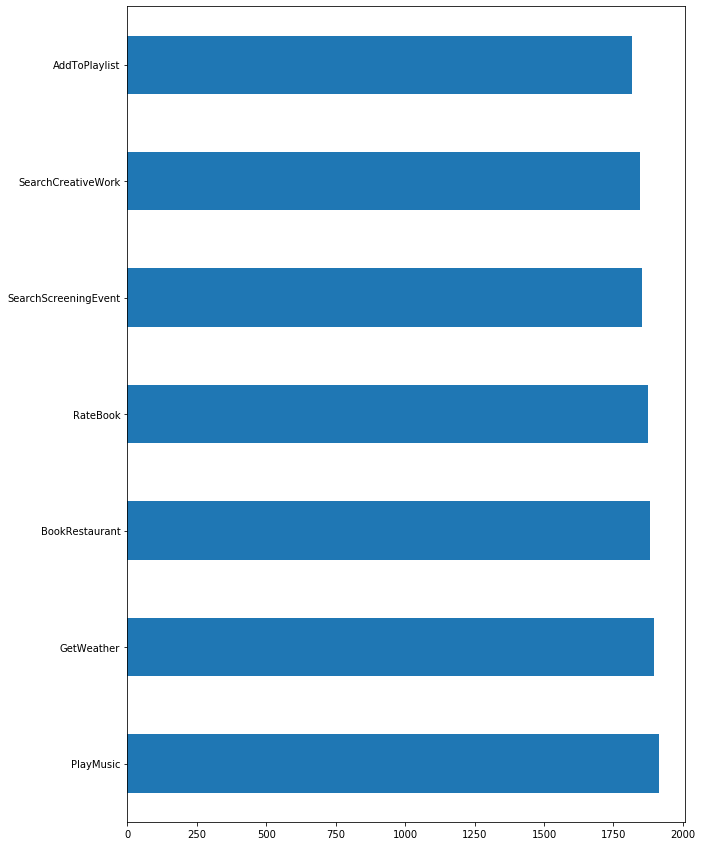

In [5]:
df_train['intent'].value_counts().plot(kind='barh', figsize=(10,15))

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13083 entries, 0 to 13082
Data columns (total 2 columns):
sentence    13083 non-null object
intent      13083 non-null object
dtypes: object(2)
memory usage: 204.5+ KB


In [7]:
df_train.describe()

,sentence,intent
count,13083,13083
unique,12894,7
top,find the movie schedule,PlayMusic
freq,9,1913


## 4) Pré-processamento dos dados

In [8]:
##Pré-processamento

df_train['tuples'] = df_train.apply(
    lambda row: (row['sentence'],row['intent']), axis=1)
train = df_train['tuples'].tolist()

train[:1]

[('add step to me to the 50 clásicos playlist ', 'AddToPlaylist')]

In [0]:
#functions from spacy documentation
def pre_prod_cat(train_data,labels):
        
        listCat=[]
        for row in train_data:
            
            listIntent={ ""+intent+"":1  if(intent==row[1])  else 0  for intent in labels}
            
            listCat.append(listIntent)
        return listCat

def load_data(limit=0, split=0.8):
    train_data = train
    np.random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    split = int(len(df_train) * split)
    cats = pre_prod_cat(train_data,labels_intent)
    
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
       
        for label, score in doc.cats.items():
            
            
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}


n_texts=len(df_train)



In [10]:
##Loading e separação dos dados de treino em treinamento e válidação

labels_intent= set(df_train['intent'])
print(labels_intent)

(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
print("Using {} examples ({} training, {} evaluation)"
      .format(n_texts, len(train_texts), len(dev_texts)))
train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))


{'PlayMusic', 'RateBook', 'BookRestaurant', 'GetWeather', 'SearchScreeningEvent', 'AddToPlaylist', 'SearchCreativeWork'}
Using 13083 examples (10466 training, 2617 evaluation)


In [11]:
train_data[0:1]

[('what is the forecast for sanilac petroglyphs historic state park',
  {'cats': {'AddToPlaylist': 0,
    'BookRestaurant': 0,
    'GetWeather': 1,
    'PlayMusic': 0,
    'RateBook': 0,
    'SearchCreativeWork': 0,
    'SearchScreeningEvent': 0}})]

## 5) Treinando o Modelo


In [12]:

result=[]

## Escolhendo o pipeline de classificação Textual
textcat = nlp.create_pipe('textcat', config={"exclusive_classes": True,"architecture":"simple_cnn"})
nlp.add_pipe(textcat, last=True)




for intent in labels_intent:
    #print(intent)
    textcat.add_label(intent)

    
epochs=5    
# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))
    for i in range(epochs):
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=256)
        for batch in batches:
            texts, annotations = zip(*batch)
            #print(texts)
            #print('Anotation:',annotations)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                       losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  # print a simple table
              .format(losses['textcat'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f']))

Training the model...
LOSS 	  P  	  R  	  F  
0.000	0.957	0.938	0.947
0.000	0.975	0.969	0.972
0.000	0.981	0.976	0.979
0.000	0.980	0.978	0.979
0.000	0.980	0.977	0.978


## 6) Avaliando o Modelo

In [0]:
def predict_intent(doc):
    ## Escolhe a melhor classe pela maior probabilidade que o Spacy traz
    indexes = []
    intenst=[]
    for i in doc.cats:
        intenst.append(i)
        indexes.append(doc.cats[i])

    y_proba = np.ravel(indexes)
     
    sort_indexes = np.argsort(y_proba) # sort proba desc

    return intenst[sort_indexes[len(sort_indexes)-1]] 
   

In [0]:
y_real= []
y_predict=[]

##Intera cada amostra e prediz a classe de cada sentença
for index, row in df_test.iterrows():
    
    y_real.append(row['intent'])
    
   
    doc = nlp(row['sentence'])
    y_predict.append(predict_intent(doc))


In [21]:
 
print('Acurácia (teste): ' + str(accuracy_score(y_real, y_predict)))
print('Acuráácia Balanceada (teste): ' + str(balanced_accuracy_score(y_real, y_predict)))

print(classification_report(y_real, y_predict))

Acurácia (test): 0.9685264663805436
Balanced accuracy (test): 0.9698489417866953
                      precision    recall  f1-score   support

       AddToPlaylist       0.99      0.98      0.99       123
      BookRestaurant       1.00      0.98      0.99        92
          GetWeather       0.97      0.99      0.98       104
           PlayMusic       0.93      0.98      0.95        86
            RateBook       1.00      1.00      1.00        80
  SearchCreativeWork       0.93      0.93      0.93       107
SearchScreeningEvent       0.96      0.93      0.95       107

            accuracy                           0.97       699
           macro avg       0.97      0.97      0.97       699
        weighted avg       0.97      0.97      0.97       699

